#### Given the real data, the population of interval between gps fixes are found  -> (interval_population)
#### Find the appropriate distance at the interval -> (interval, distance)
Quesiton: What would be the good way to simulate new position at this point?
#### Choose x from uniform distribution of distance and find appropriate y
#### Then in combination, outputs the GPS trajectory 

#### source:
https://nathanrooy.github.io/posts/2016-09-07/haversine-with-python/

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random


## read the csv file

In [2]:
data = pd.read_csv('penguin_combined_trace.csv').iloc[1:]
header = data.columns.values
print(header)

['time index' 'Acc_x' 'Acc_y' 'Acc_z' 'Mag_x' 'Mag_y' 'Mag_z' 'Temp, C'
 'Pressure, bar' 'Latitude' 'Longitude' 'Altitude']


## shorten the data if necessary

In [3]:
print(len(data))
short_len = int(len(data))

3560799


## Find the interval population from GPS fixes

In [4]:
short_data = data.head(n=short_len)#cv 
Latitude = np.array(short_data['Latitude'].tolist())
Longitude = np.array(short_data['Longitude'].tolist())
Altitude = np.array(short_data['Altitude'].tolist())

# These values include NaN


# Calculating the interval population
interval_population = []
lat_val = 0

for i in range(len(Latitude)):
    if i == 0:
        pass
    else:
        if (math.isnan(Latitude[i])):
            lat_val = lat_val + 1
        else:
    #        print("GPS fix available")
    #         print(lat_val)
    #         print(Latitude[i])
            interval_population.append(lat_val)
            lat_val = 0

# print(random.sample(interval_population,1))
print(interval_population[0:10])
print(len(interval_population))

[1592, 1161, 1723, 2538, 1507, 7105, 2927, 1032, 989, 989]
2056


## Find the distance between each fixes/ Visualization of data

#### GPS fixes to meter conversion

43030.065265945195


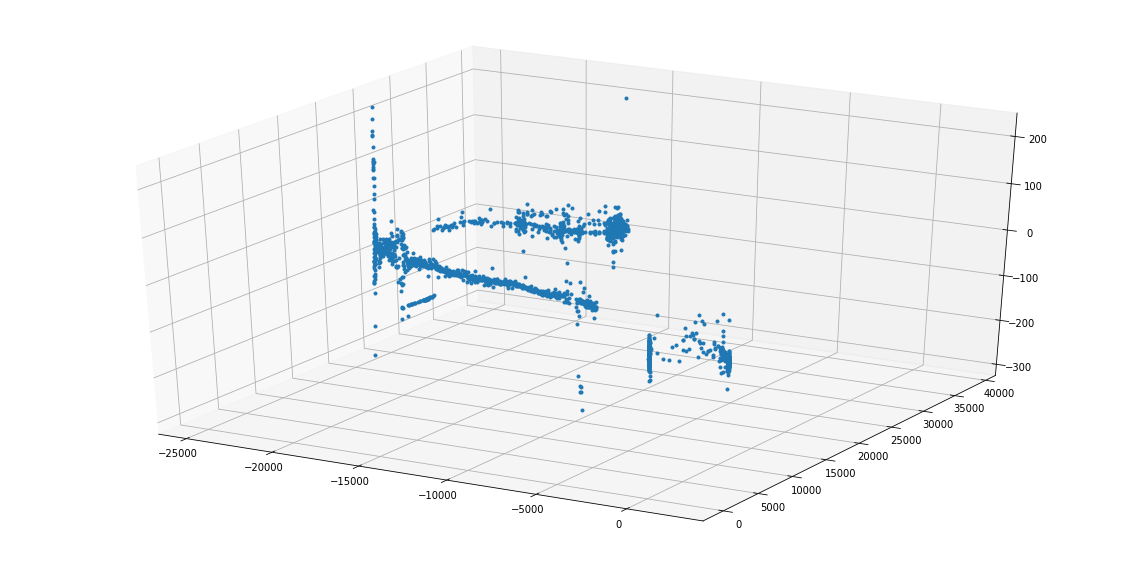

In [5]:
fx = short_data['Latitude'].dropna()
fy = short_data['Longitude'].dropna()
fz = short_data['Altitude'].dropna()

fx = np.array(fx)
fy = np.array(fy)
fz = np.array(fz)

R = 6378388.0 + fz # m
arc= 2.0*np.pi*R/360.0 # m/°
fdx = arc * np.cos(fx*np.pi/180.0) * np.hstack((0.0, np.diff(fy))) # in m
fdy = arc * np.hstack((0.0, np.diff(fx))) # in m
fdz = np.hstack((0.0, np.diff(fz)))

fmx = np.cumsum(fdx)
fmy = np.cumsum(fdy)
fmz = np.cumsum(fdz)

dx = fdx[1:]
dy = fdy[1:]
dz = fdz[1:]
    
distance_array = np.sqrt(dx**2 + dy**2 + dz**2)

fig = plt.figure(figsize=(20,10))
plot_3d = fig.gca(projection='3d')
s = 0
e = len(fmx)
plot_3d.plot(fmx[s:e], fmy[s:e], fmz[s:e],'.')

print(np.sqrt(fmx[-1]**2 + fmy[-1]**2 + fmz[-1]**2))

## Random select x,y,z from the given interval 
Needs better method

In [ ]:
def get_interval_and_distance(int_array, dist_array):
    interval = random.sample(int_array,1)[0]
#     print("interval")
#     print(interval)
    idx = random.sample(np.where(np.array(int_array) == interval)[0].tolist(),1)[0]
    distance = dist_array[idx]
    
    x = dx[idx]
    y = dy[idx]
    z = dz[idx]
    
    return interval, x, y, z

interval, x, y, z = get_interval_and_distance(interval_population,distance_array)

## Simulate GPS data 

In [ ]:
# Input: total number of fixes 
# Starting position at 0,0,0
# Output: interval, dx, dy, dz (unit: meter)


n_fix = 2000

def simulate_GPS_data(n_fix):
    x_loc = 0
    y_loc = 0
    z_loc = 0
    x_locs = []
    y_locs = []
    z_locs = []
    intervals = []

    for i in range(n_fix):
        interval, x, y, z = get_interval_and_distance(interval_population,distance_array)
        intervals.append(interval)
        x_loc += x
        y_loc += y 
        z_loc += z 
        x_locs.append(x_loc)
        y_locs.append(y_loc)
        z_locs.append(z_loc)
        
    # interval_at = np.cumsum(interval)
    # print(len(interval_at))
    # print(len(x))
    filename = open("/Users/eunsunlee/Documents/NESL/UnderwaterSensorTag/IMU_GPS_Fusion/Trajectory_Simulation/simulated_GPS_trajectories/GPS_simulation.txt",'w')
    for i in range(len(intervals)):
        print(intervals[i], x_locs[i], y_locs[i], z_locs[i] ,file = filename)
    filename.close()
        
    return intervals, x_locs, y_locs, z_locs
    
#Simulate GPS data
interval, x, y, z = simulate_GPS_data(n_fix)

# Plot
fig = plt.figure(figsize=(20,10))
plot_3d = fig.gca(projection='3d')
plot_3d.plot(x, y, z,'.')

print(np.sqrt(x[-1]**2 + y[-1]**2 + z[-1]))

2056


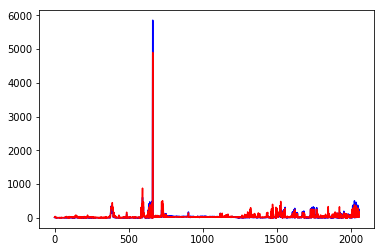

speed analysis (meter/s)


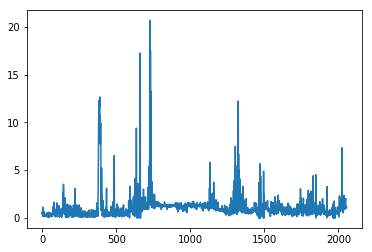

In [77]:
# Speed Analysis 
# Calculation of meters using HAversine 
meters = []
for i in range(len(fx)):
    if i == 0: 
        pass
    else:
        meters.append(Haversine((fx[i-1],fy[i-1]),(fx[i],fy[i])).meters)
        
print(len(meters))
plt.plot(meters,'b')
plt.plot(distance_array,'r')
plt.show()

print("speed analysis (meter/s)")
int_a = np.array(interval_population)
int_a.astype(float)
int_a = int_a/40
dist_a = np.array(distance_array)
speed = dist_a/int_a

plt.plot(speed)

In [44]:
import math

class Haversine:
    '''
    use the haversine class to calculate the distance between
    two lon/lat coordnate pairs.
    output distance available in kilometers, meters, miles, and feet.
    example usage: Haversine([lon1,lat1],[lon2,lat2]).feet
    
    '''
    def __init__(self,coord1,coord2):
        lon1,lat1=coord1
        lon2,lat2=coord2
        
        R=6371000                               # radius of Earth in meters
        phi_1=math.radians(lat1)
        phi_2=math.radians(lat2)

        delta_phi=math.radians(lat2-lat1)
        delta_lambda=math.radians(lon2-lon1)

        a=math.sin(delta_phi/2.0)**2+\
           math.cos(phi_1)*math.cos(phi_2)*\
           math.sin(delta_lambda/2.0)**2
        c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
        
        self.meters=R*c                         # output distance in meters
        self.km=self.meters/1000.0              # output distance in kilometers
        self.miles=self.meters*0.000621371      # output distance in miles
        self.feet=self.miles*5280               # output distance in feet

if __name__ == "__Haversine__":
    main()


# fx = short_data['Latitude'].dropna()
# fy = short_data['Longitude'].dropna()
# fz = short_data['Altitude'].dropna()

# fx = np.array(fx)[0:2]
# fy = np.array(fy)[0:2]
# fz = np.array(fz)[0:2]

# R = 6378388.0 + fz # m
# arc= 2.0*np.pi*R/360.0 # m/°
# fdx = arc * np.cos(fx*np.pi/180.0) * np.hstack((0.0, np.diff(fy))) # in m
# fdy = arc * np.hstack((0.0, np.diff(fx))) # in m
# fdz = np.hstack((0.0, np.diff(fz)))

# fmx = np.cumsum(fdx)
# fmy = np.cumsum(fdy)
# fmz = np.cumsum(fdz)


# print(fx)
# print(fdx)
# print(fx[0])
# print(fx[1])

# print(fy[0])
# print(fy[1])

# print(fdx[1])
# print(fdy[1])
# print(fdz[1])
# print("distance moved:")
# print(np.sqrt(fdx[1]**2 + fdy[1]**2 + fdz[1]**2))

# # np.where(np.array(Latitude)==fx[0])
# # np.where(np.array(Latitude)==fx[1])
# print(Latitude[0])
# print(Latitude[1593])
# print("meters moved: ")
# print(Haversine((fx[0],fy[0]),(fx[1],fy[1])).meters )
# time = np.array(short_data['time index'].tolist())
# print("time")
# print(time[0])
# print(time[1593])

# #1592 interval in between 
# # approximately 1592/40 seconds 
# print("time passed calculated from interval(second)")
# print(1592/40)

# print("penguin traveled at least 13 meter in 39.8 seconds ")
# print(13/39.8)
# print("penguin at least travels")
# print("0.33 meters per second")

In [ ]:
## other correlation etc 

In [ ]:
# print(np.corrcoef(interval_population,distance))
# print(len(interval_population))
# print(len(distance))

# plt.plot(interval_population,distance,'.')
# plt.show()

# int_noout = np.array(interval_population)
# dist_noout = np.array(distance)

# for i in range(4):
#     idx = np.argmax(int_noout)
#     print(idx)
#     int_noout = np.delete(int_noout,idx)
#     dist_noout = np.delete(dist_noout,idx)
    
# plt.plot(int_noout,dist_noout,'.')